In [1]:
# import packages: numpy, pandas, nltk, spacy, and sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
from sklearn.decomposition import PCA
import time
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import cvxpy as cvx
import random
import copy
import string
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# set seed for consistency
np.random.seed(2019)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# package installation

#!spacy download en_core_web_lg

In [0]:
# dimension setting function
# if this code fell to run (can't recognize package en_core_web_lg), then run the line below
# !spacy download en_core_web_lg
# then restart the kernel. 

nlp = spacy.load('en_core_web_lg')

### **Read the data**

In [4]:
# spam dataset: https://www.kaggle.com/uciml/sms-spam-collection-dataset/data
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vRzkLSK-20SdsUID8II56gg6-qM6fxc2fAAbeCanWEu5jvPdFxDxcXFZs2z87mbj4P8EuH8kmKufzj5/pub?gid=555592479&single=true&output=csv")

# only takes the 1st 2 columns (type and content)
data = data[["v1", "v2"]]
# rename the columns
data.columns = ["Type", "Content"]

# check null values
for column in data.columns:
  if sum(data[column].isnull()) != 0:
    print("Exist Null value: ", column)

print("Number of data points:", len(data))
print("")
data.head()

Number of data points: 5572



,Type,Content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# quick description on the data
data.groupby("Type").describe()

Content                                                               
       count unique                                                top freq
Type                                                                       
ham     4825   4516                             Sorry, I'll call later   30
spam     747    647  Please call our customer service representativ...    4

### **Data Preprocessing**

In [0]:
# remove punctuations and stopwords

def txt_preprocess(txt):
  txt = txt.translate(str.maketrans('', '', string.punctuation))
  txt = [word for word in txt.split() if word.lower() not in stopwords.words('english')]
  return " ".join(txt)

# make a copy of the data so that we won't change the original dataframe
process_text = copy.deepcopy(data["Content"])

# preprocess the data
process_text = process_text.apply(txt_preprocess)

In [0]:
# map the data into 300 dimensions spacy vector space
train_nlps = [nlp(text) for text in process_text]
train_vecs = [text.vector for text in train_nlps]

# feature matrix
X = np.array(train_vecs)

In [0]:
# use pca to remove the dimension of the data: 300 -> 30 dimensions: keep those with highest variance
pca = PCA(n_components=30)
X = pca.fit_transform(X)

In [0]:
# transform the type data: logistic regression {0,1}; SVM {-1,1}
Y_lgr = np.array([data["Type"].map({"ham":  0, 'spam':1})]).T
Y_svm = np.array([data["Type"].map({"ham": -1, 'spam':1})]).T

In [0]:
# split the dataset into train and test
X_train, X_test, Y_train_lgr, Y_test_lgr = train_test_split(X, 
                                                        Y_lgr, test_size=0.2, random_state=20)

# this code is to have consistency between train and test (for both approaches to have same dataset)
# logistics: {0,1} * 2 --> {0,2} - 1 --> {-1,1}: the values suitable for SVM
Y_train_svm = Y_train_lgr*2-1
Y_test_svm = Y_test_lgr*2-1

In [11]:
# check dimension
m = X_train.shape[0]
n = X_train.shape[1]
ones = np.ones((n,1))

print(m, "data points")
print(n, "features")

4457 data points
30 features


logistic with L_1 norm

In [0]:
# error check
def error(scores, labels):
  return np.mean((np.sign(scores + 1)//2) != labels)

In [0]:
# define variables
coeff = cvx.Variable((n,1))
slack_1 = cvx.Variable((n,1), nonneg = True)

# Parameters 
lambd = cvx.Parameter(nonneg=True)

# cost function
cost = cvx.sum(cvx.multiply(Y_train_lgr, X_train @ coeff) - cvx.logistic(X_train @ coeff))

# objective function: -1/m*cost + regularization
obj = cvx.Minimize(-cost/m + lambd * (ones.T@slack_1))

# constraints
con = [coeff >= -slack_1, coeff <= slack_1]

# define problem
problem = cvx.Problem(obj, con)

In [14]:
# Try out with no regularization: lambd = 0
lambd.value = 0
problem.solve(solver = cvx.ECOS)
print("Results for logistic regression without regularization:")
print("Status:", problem.status)

# calculate train/test error
train_error_lgr = error((X_train @ coeff).value, Y_train_lgr)
test_error_lgr = error((X_test @ coeff).value, Y_test_lgr)

print("Train error:", train_error_lgr)
print("Test error:", test_error_lgr)

Results for logistic regression without regularization:
Status: optimal
Train error: 0.34305586717522996
Test error: 0.34439461883408073


In [0]:
# number of values for lambd: 
trials = 20

# to store the error rate
train_error_lgr_1 = []
test_error_lgr_1 = []

# space out the values by log of 10: to 10^-2 to 10^0
lambda_vals = np.logspace(-2, 0, trials)

# try out with different lambd values
for i in range(trials):
  lambd.value = lambda_vals[i]
  problem.solve(solver = cvx.ECOS)

  # store the error rate
  train_error_lgr_1 += [error((X_train @ coeff).value, Y_train_lgr)]
  test_error_lgr_1 += [error((X_test @ coeff).value, Y_test_lgr)]

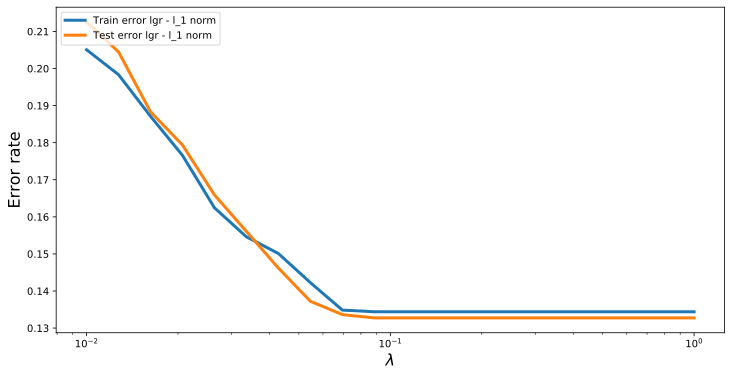

In [16]:
# plot the error rates
plt.figure(figsize=(12,6))
plt.plot(lambda_vals, train_error_lgr_1, label="Train error lgr - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, test_error_lgr_1, label="Test error lgr - l_1 norm", linewidth = 3)
plt.xscale("log")
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Error rate", fontsize=16)
plt.show()

logistic with linf norm

In [0]:
# variables
coeff = cvx.Variable((n,1))
slack_inf = cvx.Variable((1,1))

# define parameters
lambd = cvx.Parameter(nonneg=True)

# cost functiton
cost = cvx.sum(cvx.multiply(Y_train_lgr, X_train @ coeff) - cvx.logistic(X_train @ coeff))

# objective function
obj = cvx.Minimize(-cost/m + lambd * slack_inf)

# constraint for slack variable
con = [coeff >= -slack_inf@ones, coeff <= slack_inf@ones]

# define problem
problem = cvx.Problem(obj, con)

In [0]:
# number of values for lambd: 
trials = 20

# to store the error rate
train_error_lgr_inf = []
test_error_lgr_inf = []

# space out the values by log of 10: to 10^-2 to 10^0
lambda_vals = np.logspace(-2, 0, trials)

# try out with different lambd values
for i in range(trials):
  lambd.value = lambda_vals[i]
  problem.solve(solver = cvx.ECOS)
  
  # store the error rate
  train_error_lgr_inf += [error((X_train @ coeff).value, Y_train_lgr)]
  test_error_lgr_inf += [error((X_test @ coeff).value, Y_test_lgr)]

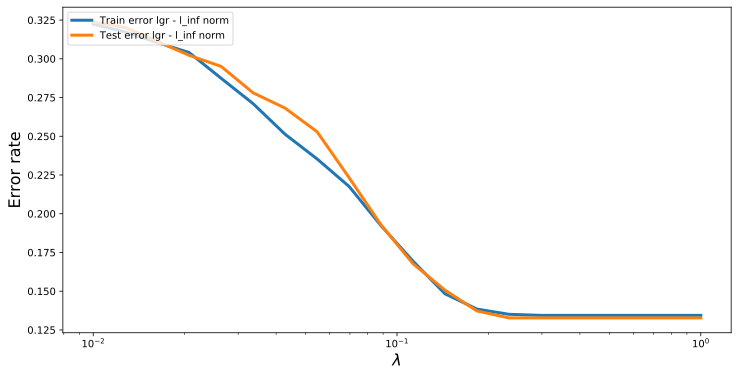

In [19]:
# plot the error rates
plt.figure(figsize=(12,6))
plt.plot(lambda_vals, train_error_lgr_inf, label="Train error lgr - l_inf norm", linewidth = 3)
plt.plot(lambda_vals, test_error_lgr_inf, label="Test error lgr - l_inf norm", linewidth = 3)
plt.xscale("log")
plt.legend(loc="upper left")
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Error rate", fontsize=16)
plt.show()

Logistic summary

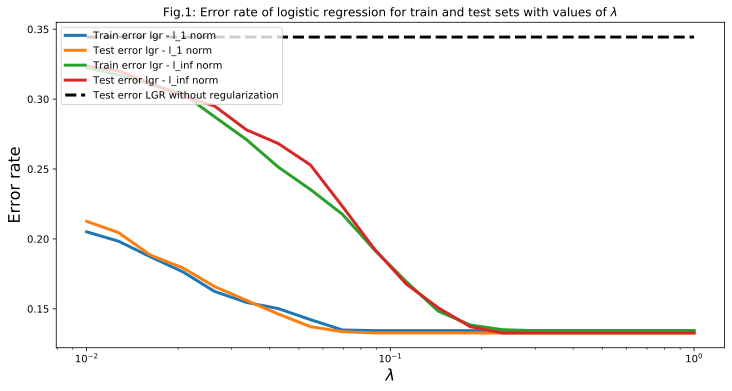

In [20]:
# plot the combines error rates
plt.figure(figsize=(12,6))
plt.plot(lambda_vals, train_error_lgr_1, label="Train error lgr - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, test_error_lgr_1, label="Test error lgr - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, train_error_lgr_inf, label="Train error lgr - l_inf norm", linewidth = 3)
plt.plot(lambda_vals, test_error_lgr_inf, label="Test error lgr - l_inf norm", linewidth = 3)
plt.hlines(test_error_lgr, 0.01, 1, linestyle = "--", label="Test error LGR without regularization", linewidth = 3)
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Error rate", fontsize=16)
plt.title("Fig.1: Error rate of logistic regression for train and test sets with values of $\lambda$")
plt.show()

SVM with L1 norm

In [0]:
# define variables
coeff = cvx.Variable((n,1))
v = cvx.Variable()
slack_1 = cvx.Variable((n,1), nonneg = True)

# cost functions
cost = cvx.sum(cvx.pos(1 - cvx.multiply(Y_train_svm, X_train*coeff - v)))

# parameters
lambd = cvx.Parameter(nonneg=True)

# objective function
obj = cvx.Minimize(cost/m + lambd * (ones.T@slack_1))

# constraint
con = [coeff >= -slack_1, coeff <= slack_1]

# define problem
problem = cvx.Problem(obj, con)

In [22]:
# try out with out regularization
lambd.value = 0
problem.solve(solver = cvx.ECOS)
print("Results for SVM without regularization:")
print("Status:", problem.status)

train_error_svm = np.mean(Y_train_svm != np.sign(X_train.dot(coeff.value) - v.value))
test_error_svm = np.mean(Y_train_svm != np.sign(X_train.dot(coeff.value) - v.value))

print("Train error:", train_error_svm)
print("Test error:", test_error_svm)

Results for SVM without regularization:
Status: optimal
Train error: 0.060578864707202154
Test error: 0.060578864707202154


In [0]:
# number of values for lambd: 
trials = 20

# to store the error rate
train_error_svm_1 = []
test_error_svm_1 = []

# space out the values by log of 10: to 10^-2 to 10^0
lambda_vals = np.logspace(-2, 0, trials)

# try out with different lambd values
for i in range(trials):
    lambd.value = lambda_vals[i]
    problem.solve(solver = cvx.ECOS)

    # store the error rate
    train_error_svm_1 += [np.mean(Y_train_svm != np.sign(X_train.dot(coeff.value) - v.value))]
    test_error_svm_1 += [np.mean(Y_test_svm != np.sign(X_test.dot(coeff.value) - v.value))]

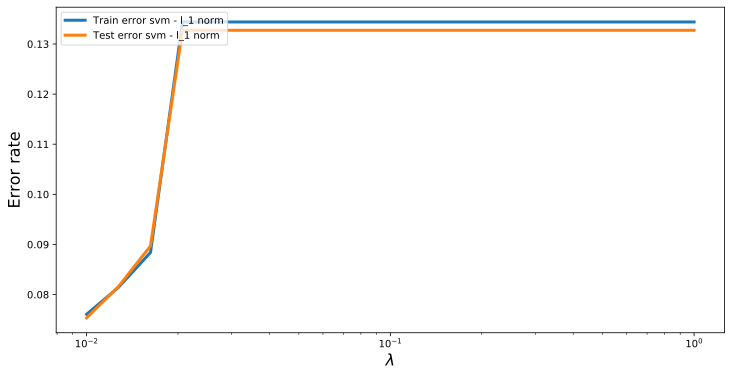

In [24]:
plt.figure(figsize=(12,6))
plt.plot(lambda_vals, train_error_svm_1, label="Train error svm - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, test_error_svm_1, label="Test error svm - l_1 norm", linewidth = 3)
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Error rate", fontsize=16)
plt.show()

SVM linf

In [0]:
# define variable
coeff = cvx.Variable((n,1))
v = cvx.Variable()
slack_inf = cvx.Variable((1,1))

# cost function
cost = cvx.sum(cvx.pos(1 - cvx.multiply(Y_train_svm, X_train*coeff - v)))

# parameters
lambd = cvx.Parameter(nonneg=True)

# objective function
obj = cvx.Minimize(cost/m + lambd * slack_inf)

# constraint
con = [coeff >= -slack_inf@ones, coeff <= slack_inf@ones]

# define problem
problem = cvx.Problem(obj, con)

In [0]:
# number of values for lambd: 
trials = 20

# to store the error rate
train_error_svm_inf = []
test_error_svm_inf = []

# space out the values by log of 10: to 10^-2 to 10^0
lambda_vals = np.logspace(-2, 0, trials)

# try out with different lambd values
for i in range(trials):
    lambd.value = lambda_vals[i]
    problem.solve(solver = cvx.ECOS)
    
    # store the error rate
    train_error_svm_inf += [np.mean(Y_train_svm != np.sign(X_train.dot(coeff.value) - v.value))]
    test_error_svm_inf += [np.mean(Y_test_svm != np.sign(X_test.dot(coeff.value) - v.value))]

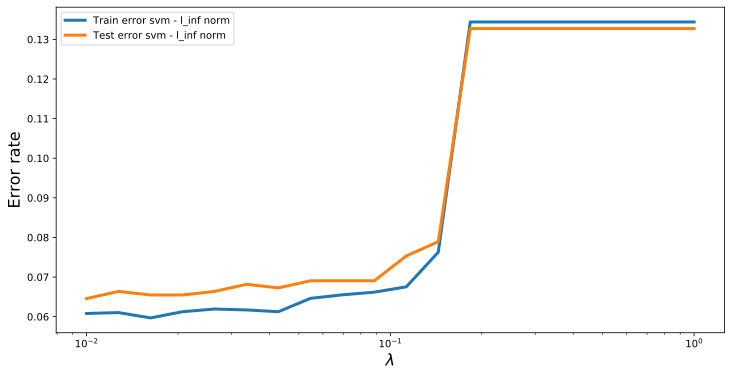

In [27]:
plt.figure(figsize=(12,6))
plt.plot(lambda_vals, train_error_svm_inf, label="Train error svm - l_inf norm", linewidth = 3)
plt.plot(lambda_vals, test_error_svm_inf, label="Test error svm - l_inf norm", linewidth = 3)
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Error rate", fontsize=16)
plt.show()

SVM Summary

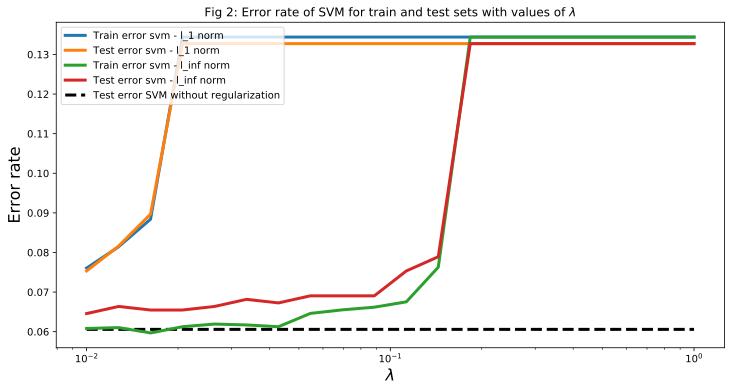

In [28]:
plt.figure(figsize=(12,6))
plt.plot(lambda_vals, train_error_svm_1, label="Train error svm - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, test_error_svm_1, label="Test error svm - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, train_error_svm_inf, label="Train error svm - l_inf norm", linewidth = 3)
plt.plot(lambda_vals, test_error_svm_inf, label="Test error svm - l_inf norm", linewidth = 3)
plt.hlines(test_error_svm, 0.01, 1, linestyle = "--", label="Test error SVM without regularization", linestyles= "-", linewidth = 3)
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Error rate", fontsize=16)
plt.title("Fig 2: Error rate of SVM for train and test sets with values of $\lambda$")
plt.show()

Total results

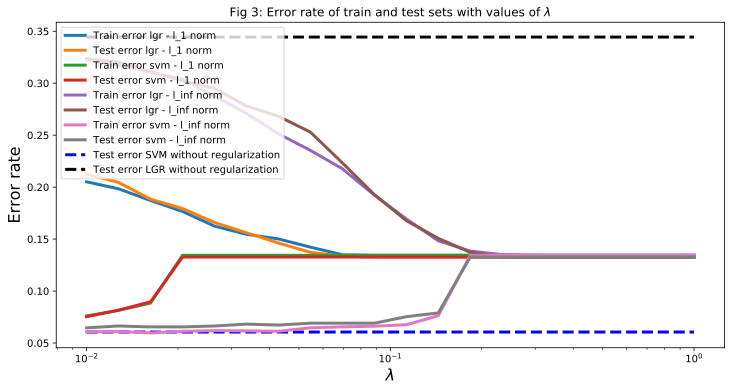

In [29]:
plt.figure(figsize=(12,6))
plt.plot(lambda_vals, train_error_lgr_1, label="Train error lgr - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, test_error_lgr_1, label="Test error lgr - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, train_error_svm_1, label="Train error svm - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, test_error_svm_1, label="Test error svm - l_1 norm", linewidth = 3)
plt.plot(lambda_vals, train_error_lgr_inf, label="Train error lgr - l_inf norm", linewidth = 3)
plt.plot(lambda_vals, test_error_lgr_inf, label="Test error lgr - l_inf norm", linewidth = 3)
plt.plot(lambda_vals, train_error_svm_inf, label="Train error svm - l_inf norm", linewidth = 3)
plt.plot(lambda_vals, test_error_svm_inf, label="Test error svm - l_inf norm", linewidth = 3)
plt.hlines(test_error_svm, 0.01, 1, linestyle = "--", label="Test error SVM without regularization", colors = "blue", linestyles= "-", linewidth = 3)
plt.hlines(test_error_lgr, 0.01, 1, linestyle = "--", label="Test error LGR without regularization", linestyles= "-", linewidth = 3)
plt.xscale('log')
plt.legend(loc='upper left')
plt.xlabel(r"$\lambda$", fontsize=16)
plt.ylabel("Error rate", fontsize=16)
plt.title("Fig 3: Error rate of train and test sets with values of $\lambda$")
plt.show()